## Evaluating CF generation
1. Probability Increase
2. proximity
3. sparsity
4. Cohesive


In [1]:
import pandas as pd
import torch.nn as nn
import torch
import os
import numpy as np
from pickle import dump , load
import pickle


In [2]:
import matplotlib.pyplot as plt

def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [3]:
class AdultClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(13, 64)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 128)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(128, 32)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.act1(self.hidden1(x)))
        x = self.dropout(self.act2(self.hidden2(x)))
        x = self.dropout(self.act3(self.hidden3(x)))
        x = self.dropout(self.act4(self.hidden4(x)))
        # x = self.output(x)
        x = self.act_output(self.output(x))
        return x
    
    
def load_model():
    model = torch.load('./../model_training/adult_credit__model')
    model.eval()
    return model

def eval_model(model, input, scaler, columns_to_standardize):
    model.eval()
    # print(input)
    input = input.reshape(-1, 13)
    input = torch.tensor(input, dtype=torch.float32)
    input = input.numpy()
    input[:, columns_to_standardize] = scaler.transform(input[:, columns_to_standardize])
    input = torch.from_numpy(input).type(torch.float)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0][0]

def load_scaler(scaler_loc):
    return load(open(scaler_loc, 'rb'))

def load_data(data):
    return np.load(data)


def save_dict(d, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

columns_to_standardize = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]

In [4]:
model = load_model()
scaler = load_scaler('./../model_training/StandardScaler.pkl')

### Evaluate average probability shift

In [5]:
def evaluate_model_for_df(df , model, scaler, columns_to_standardize):
    probability_list = []
    if df.shape[0] == 0:
        return 0
    else:
        for index, row in df.iterrows():
            x = row.to_numpy()
            prob = eval_model(model, x, scaler, columns_to_standardize)
            probability_list.append(prob)
        return sum(probability_list)/len(probability_list)
        

def average_probability_shift(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model, scaler, columns_to_standardize):
    metric_dict = {'initial_prob' : [],
                   'dice_prob' : [],
                   'Our_method_prob' : [],
                   'certif_prob' : [],
                   'GE_NSGAII_prob': []}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        # print(i)
        input_array_location = input_data_loc + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        prob = eval_model(model,  input, scaler, columns_to_standardize)
        # print(prob)
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        metric_dict['initial_prob'].append(prob)
        metric_dict['dice_prob'].append(evaluate_model_for_df(dice_df, model, scaler, columns_to_standardize ))
        metric_dict['Our_method_prob'].append(evaluate_model_for_df(Our_method_df, model, scaler, columns_to_standardize))
        metric_dict['certif_prob'].append(evaluate_model_for_df(certif_df, model, scaler, columns_to_standardize))
        metric_dict['GE_NSGAII_prob'].append(evaluate_model_for_df(NSGAII_df, model, scaler, columns_to_standardize))
        
    return metric_dict
        

In [6]:
input_data_loc = './../output/NSGAIII_multi/'
dice_loc = 'Dice_cf/'
ge_cf_loc = 'Ge_cf/'
ge_nsga2_loc = 'Ge_NSGAII_cf/'
certif_cf_loc = 'Certif_cf/'

metric = average_probability_shift(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model, scaler, columns_to_standardize)

In [8]:
def average_shift(metric):
    metric_dict = {}
    dice_shift = []
    our_method_shift = []
    certif_shift = []
    nsga2_shift = []
    for i in range(0, 30):
        if metric['dice_prob'][i]!= 0:
            dice_shift.append(metric['dice_prob'][i] - metric['initial_prob'][i])
        else:
            dice_shift.append(0)
        
        if metric['Our_method_prob'][i]!= 0:
            our_method_shift.append(metric['Our_method_prob'][i] - metric['initial_prob'][i])
        else:
            our_method_shift.append(0)
        
        if metric['certif_prob'][i]!= 0:
            certif_shift.append(metric['certif_prob'][i] - metric['initial_prob'][i])
        else:
            certif_shift.append(0)
        
        if metric['GE_NSGAII_prob'][i]!= 0:
            nsga2_shift.append(metric['GE_NSGAII_prob'][i] - metric['initial_prob'][i])
        else:
            nsga2_shift.append(0)
        
    
    metric_dict['Dice'] =     sum(dice_shift)/len(dice_shift)
    metric_dict['Our_method'] = sum(our_method_shift)/len(our_method_shift)
    metric_dict['Certif'] = sum(certif_shift)/len(certif_shift)
    metric_dict['GE_NSGAII'] = sum(nsga2_shift)/len(nsga2_shift)
    
    d = {'Dice': dice_shift, 'Certif': certif_shift,
                              'Our_method': our_method_shift, 'GE_NSGAII':nsga2_shift}
    
    return metric_dict, d
        
        
    

In [9]:
output, daf = average_shift(metric)
save_dict(daf, 'data_statistical_test/average_shift.pickle')

In [16]:
output

{'Dice': 0.9783198724610976,
 'Our_method': 0.896846669709902,
 'Certif': 0.9071564603771243,
 'GE_NSGAII': 0.8909470060539845}

## Proximity comparison : average distance of counterfactuals from input 
- lower the better

In [10]:
from sklearn.metrics import DistanceMetric

def mean(l):
    return sum(l)/len(l)

def calculate_l2_distance_sklearn(array, df):
    
    # Create a DistanceMetric object for Euclidean distance
    if df.shape[0] == 0:
        print("no counterfactuals")
        return []
    
    euclidean = DistanceMetric.get_metric('euclidean')
    
    # Ensure array is 2D for pairwise
    array_2d = array.reshape(1, -1)
    
    # Calculate distances using the pairwise method
    distances = euclidean.pairwise(array_2d, df.values)
    
    # Convert distances to a list
    distances_list = distances.flatten().tolist()
    
    return distances_list


def calculate_proximity(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model):
    metric_dict = {'Dice' : [],
                   'Our_method' : [],
                   'Certif' : [],
                   'GE_NSGAII': []}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        # print(i)
        input_array_location = input_data_loc + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        # print(i)
        # print(prob)
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        if dice_df.shape[0] > 0:
            metric_dict['Dice'].append(mean(calculate_l2_distance_sklearn(input, dice_df)))
        if Our_method_df.shape[0] > 0:
            metric_dict['Our_method'].append(mean(calculate_l2_distance_sklearn(input, Our_method_df)))
        if certif_df.shape[0] > 0:
            metric_dict['Certif'].append(mean(calculate_l2_distance_sklearn(input, certif_df)))
        if NSGAII_df.shape[0] > 0:
            metric_dict['GE_NSGAII'].append(mean(calculate_l2_distance_sklearn(input, NSGAII_df)))
    
    d = {'Dice': metric_dict['Dice'], 'Certif': metric_dict['Certif'],
                              'Our_method': metric_dict['Our_method'], 'GE_NSGAII':metric_dict['GE_NSGAII']}
    
    out_metric = {}
    for key, value in metric_dict.items():
        out_metric[key] = mean(value)
    return out_metric, d
        

In [11]:
proximity, d_proximity = calculate_proximity(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model)

save_dict(d_proximity, 'data_statistical_test/proximity.pickle')
proximity

{'Dice': 95155.27751849437,
 'Our_method': 10866.941961258532,
 'Certif': 81474.86874207016,
 'GE_NSGAII': 12453.60444477707}

## Sparsity: Average feature change in inputs
- lower the better

In [12]:
def calculate_feature_changes(array, df):
    changes = []
    for index, row in df.iterrows():
        # Compare array with row and count the number of differences
        # print('row {} and array {}'.format(row.values, array))
        num_changes = np.sum(array != row.values)
        # print('num_changes: {}'.format(num_changes))
        changes.append(num_changes)
    return changes


def calculate_sparsity(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model):
    metric_dict = {'Dice' : [],
                   'Our_method' : [],
                   'Certif' : [],
                   'GE_NSGAII': []}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        # print(i)
        input_array_location = input_data_loc + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        # print(i)
        # print(prob)
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        if dice_df.shape[0] > 0:
            metric_dict['Dice'].append(mean(calculate_feature_changes(input, dice_df)))
        if Our_method_df.shape[0] > 0:
            metric_dict['Our_method'].append(mean(calculate_feature_changes(input, Our_method_df)))
        if certif_df.shape[0] > 0:
            metric_dict['Certif'].append(mean(calculate_feature_changes(input, certif_df)))
        if NSGAII_df.shape[0] > 0:
            metric_dict['GE_NSGAII'].append(mean(calculate_feature_changes(input, NSGAII_df)))
    
    d = {'Dice': metric_dict['Dice'], 'Certif': metric_dict['Certif'],
                              'Our_method': metric_dict['Our_method'], 'GE_NSGAII':metric_dict['GE_NSGAII']}
    out_metric = {}
    for key, value in metric_dict.items():
        out_metric[key] = mean(value)
    return out_metric, d

In [13]:
sparsity, d_sparsity = calculate_sparsity(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model)

save_dict(d_sparsity, 'data_statistical_test/sparsity.pickle')
sparsity

{'Dice': 12.017678571428572,
 'Our_method': 2.1388966997055237,
 'Certif': 11.892592592592596,
 'GE_NSGAII': 2.2975839438339434}

## Cohesive : how close these individuals are with each other
1. 1 / Average distance between all the individual
2. higher the better

In [14]:
def distance_between_all_counterfactuals(df):
    if not df.applymap(lambda x: isinstance(x, (int, float))).all().all():
        raise ValueError("DataFrame contains non-numeric data.")
    
    data = df.values
    euclidean = DistanceMetric.get_metric('euclidean')
    dist_matrix = euclidean.pairwise(data)
    
    distances = []
    n = len(dist_matrix)
    for i in range(n):
        for j in range(i + 1, n):
            distances.append(dist_matrix[i, j])
    
    return distances

def calculate_cohesive(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model):
    metric_dict = {'Dice' : [],
                   'Our_method' : [],
                   'Certif' : [],
                   'GE_NSGAII': []}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        # print(i)
        input_array_location = input_data_loc + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        # print(i)
        # print(prob)
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
    
        if dice_df.shape[0] > 1:
            metric_dict['Dice'].append(mean(distance_between_all_counterfactuals(dice_df)))
        if Our_method_df.shape[0] > 1:
            metric_dict['Our_method'].append(mean(distance_between_all_counterfactuals(Our_method_df)))
        if certif_df.shape[0] > 1:
            metric_dict['Certif'].append(mean(distance_between_all_counterfactuals(certif_df)))
        if NSGAII_df.shape[0] > 1:
            metric_dict['GE_NSGAII'].append(mean(distance_between_all_counterfactuals(NSGAII_df)))
    
    d = {'Dice': metric_dict['Dice'], 'Certif': metric_dict['Certif'],
                              'Our_method': metric_dict['Our_method'], 'GE_NSGAII':metric_dict['GE_NSGAII']}
    
    out_metric = {}
    for key, value in metric_dict.items():
        out_metric[key] = 1/mean(value)
    return out_metric, d

In [15]:
cohesive, d_cohesive = calculate_cohesive(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model)

save_dict(d_cohesive, 'data_statistical_test/cohesive.pickle')

cohesive

{'Dice': 8.339023292968976e-06,
 'Our_method': 0.0002140576784870083,
 'Certif': 1.4467454505055112e-05,
 'GE_NSGAII': 0.00014919929179893122}

In [16]:
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import normalize

def normalize_dict(data_dict):
    values = np.array(list(data_dict.values())).reshape(1, -1)
    normalized_values = normalize(values, norm='l1')[0]
    normalized_dict = {key: normalized_values[i] for i, key in enumerate(data_dict.keys())}
    return normalized_dict


def find_mu_sigma(input_data_loc, output_column_name):
    data = pd.read_csv(input_data_loc)
    data.drop([output_column_name], axis=1, inplace=True)
    mu = np.mean(data.values, axis=0)
    sigma = np.cov(data.values.T)
    return mu, sigma


def mean_mahabolis_distances(df, mu, sigma):
    dist= []
    for index, row in df.iterrows():
        x = row.to_numpy()
        d = mahalanobis(x, mu, np.linalg.inv(sigma))
        dist.append(d)
    return mean(dist)
        
            


def closer_to_data_manifold(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, output_column_name, input_file_name):
    metric_dict = {'Dice' : [],
                   'Our_method' : [],
                   'Certif' : [],
                   'GE_NSGAII': []}
    
    mu, sigma = find_mu_sigma(input_file_name, output_column_name)
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        # print(i)
        input_array_location = input_data_loc + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
    
        if dice_df.shape[0] > 1:
            metric_dict['Dice'].append(mean_mahabolis_distances(dice_df, mu, sigma))
        if Our_method_df.shape[0] > 1:
            metric_dict['Our_method'].append(mean_mahabolis_distances(Our_method_df, mu, sigma))
        if certif_df.shape[0] > 1:
            metric_dict['Certif'].append(mean_mahabolis_distances(certif_df, mu, sigma))
        if NSGAII_df.shape[0] > 1:
            metric_dict['GE_NSGAII'].append(mean_mahabolis_distances(NSGAII_df, mu, sigma))
    
    d = {'Dice': metric_dict['Dice'], 'Certif': metric_dict['Certif'],
                              'Our_method': metric_dict['Our_method'], 'GE_NSGAII':metric_dict['GE_NSGAII']}
    
    out_metric = {}
    for key, value in metric_dict.items():
        out_metric[key] = 1/mean(value)
    
    out_metric = normalize_dict(out_metric)
    
    return out_metric, d

input_file_name = './../test_balanced.csv'
output_column_name = 'class'

conformity_dict, d_conformity = closer_to_data_manifold(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, output_column_name, input_file_name)
print(conformity_dict)

save_dict(d_conformity, 'data_statistical_test/conformity.pickle')

{'Dice': 0.16987851601341056, 'Our_method': 0.2570345672327851, 'Certif': 0.32639165644264, 'GE_NSGAII': 0.2466952603111644}


## goodness of counterfactuals 
goodness = (avg_probability_increase * cohesiveness * Conformity)/(proximity * sparsity)
- avg_probability_increase : increase the average probability of class
- cohesiveness : generated counterfactuals should be close to each other
- proximity: close to the input space
- sparsity: minimum feature change
- conformity : closeness to data manifold 
- higher is better

In [32]:



def goodness_of_cf(avg_prob_dict, cohesive_dict,  proximity_dict, sparsity_dict, conformity_dict):
    goodness_of_cf_dict = {}
    for key, value in avg_prob_dict.items():
        goodness_of_cf_dict[key] = (avg_prob_dict[key] * cohesive_dict[key] * conformity_dict[key])/(proximity_dict[key] * sparsity_dict[key])
    return normalize_dict(goodness_of_cf_dict)

goodness_of_cf = goodness_of_cf(output, cohesive, proximity, sparsity, conformity_dict)
goodness_of_cf

{'Dice': 0.00037009464104633956,
 'Our_method': 0.6482986633907832,
 'Certif': 0.0013500346044288962,
 'GE_NSGAII': 0.34998120736374166}

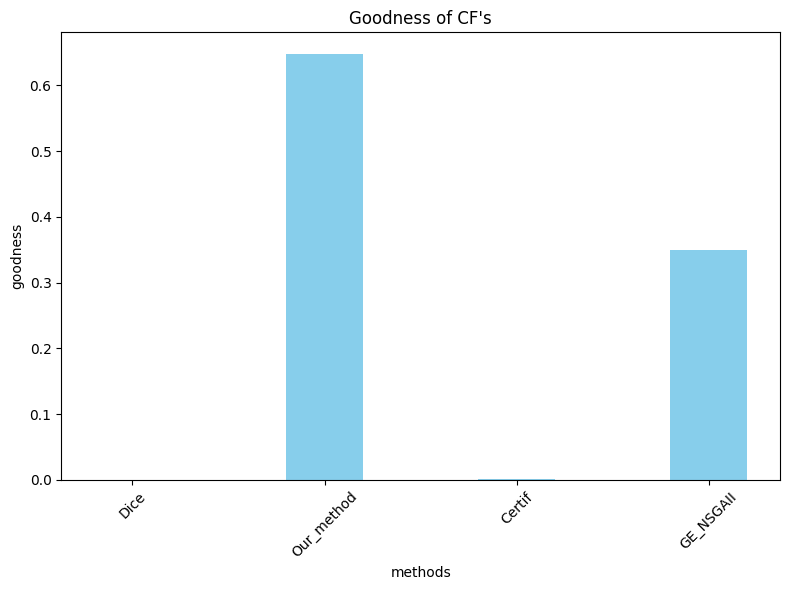

In [33]:
plot_bar_graph(goodness_of_cf, title="Goodness of CF's", xlabel="methods", ylabel="goodness")